In [1]:
#############################################################
### Andras Horvath, Ting Lee, Alan Bohnert                ###
### Final Project for MATH 5399 (Summer 2023 term)        ###
### Using Neural Networks to Predict Stock Market Returns ###
#############################################################

### Background ###
# A very common modern route taken to deal with time series data is using Recurrent Neural Networks 
# or LSTMs. There are also numerous other methods devised by Economists and Statisticians often taught
# in a official course covering Time Series data. One book I have read through for such a course which
# I would highly recommend is "Analysis of Financial Time Series" by Ruey S. Tsay. Some of these methods
# include Autoregressive (AR) Models, Moving Average (MA) Models, ARMA models, Seasonal Models, Regression
# models, etc. I hope to post some of my other projects in the future on my GitHub showcasing some of these 
# other methods. Another general note I will mention here is that the S&P 500 is widely known to be White Noise.
# Since White Noise is not predictable these methods are not helpful in predicting future daily returns, but this
# does not mean these techniques cannot be applied to other stocks / time series data in order to predict future daily
# returns.

### Goals ###
# For this project we primarily wanted to experiment and apply a NN model which would take as input 3 
# days worth of data and output whether a big negative, small negative, small positive, or big positive
# change in the returns would occur the next most trading day.
    
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Read a DataFrame from csv:
df = pd.read_csv('^SPX.csv', index_col = 'Date')['1950-01-03':]
# CSV file with S&P 500 Index (^SPX) was obtained from Yahoo Finance.
# The first day where trading volume wasn't zero was 1950-01-03 so we started from here.

In [2]:
# Go ahead and double check some of the data to make sure everything is as expected.
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,16.66,1260000
1950-01-04,16.85,16.85,16.85,16.85,16.85,1890000
1950-01-05,16.93,16.93,16.93,16.93,16.93,2550000
1950-01-06,16.98,16.98,16.98,16.98,16.98,2010000
1950-01-09,17.08,17.08,17.08,17.08,17.08,2520000


In [3]:
df.tail()
# Note that the data ends on 2023-06-26. This is because of when this project was completed. 
# A newer, updated version can be obtained by getting a more current CSV from Yahoo Finance.

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-20,4396.109863,4400.149902,4367.189941,4388.709961,4388.709961,4055790000
2023-06-21,4380.009766,4386.220215,4360.140137,4365.689941,4365.689941,3709330000
2023-06-22,4355.399902,4382.250000,4351.819824,4381.890137,4381.890137,3511000000
2023-06-23,4354.169922,4366.549805,4341.339844,4348.330078,4348.330078,6053620000
2023-06-26,4344.839844,4362.060059,4328.080078,4328.819824,4328.819824,3415030000


In [4]:
# Create the daily log(returns) column:
df['Return'] = df['Adj Close']/df['Adj Close'].shift(1)
print(df.head(10))
df['Log_Return'] = np.log(df['Return']) # As a general note, it is the natural log which is taken when doing this.
print(df.head(10))
Volume = df['Volume']
df['V_60'] = Volume / Volume.rolling(window=60).mean() # 60 day moving average

                 Open       High        Low      Close  Adj Close   Volume  \
Date                                                                         
1950-01-03  16.660000  16.660000  16.660000  16.660000  16.660000  1260000   
1950-01-04  16.850000  16.850000  16.850000  16.850000  16.850000  1890000   
1950-01-05  16.930000  16.930000  16.930000  16.930000  16.930000  2550000   
1950-01-06  16.980000  16.980000  16.980000  16.980000  16.980000  2010000   
1950-01-09  17.080000  17.080000  17.080000  17.080000  17.080000  2520000   
1950-01-10  17.030001  17.030001  17.030001  17.030001  17.030001  2160000   
1950-01-11  17.090000  17.090000  17.090000  17.090000  17.090000  2630000   
1950-01-12  16.760000  16.760000  16.760000  16.760000  16.760000  2970000   
1950-01-13  16.670000  16.670000  16.670000  16.670000  16.670000  3330000   
1950-01-16  16.719999  16.719999  16.719999  16.719999  16.719999  1460000   

              Return  
Date                  
1950-01-03       

In [5]:
df = df.dropna() # To remove the missing first day

l = df['Log_Return']
v_60 = df['V_60']
print(l.shape)
print(v_60.shape)

(18430,)
(18430,)


In [6]:
N = 18427
# len(df) = 18430 so last index is 18429. Therefore, if we are doing batches
# of 3, the last set would be index l[18426], l[18427] , l[18428]
# so that our y could be l[18429]. Therefore, use N = 18427.

# Let's get everything set up for the NN model:
X = np.array([])
Y = np.array([])
V = np.array([])
for i in range(N):
    x = np.array([l[i],l[i+1],l[i+2]])
    X = np.concatenate((X, x), axis = 0)
    y = np.array([l[i+3]])
    Y = np.concatenate((Y, y), axis = 0)
    v = np.array([v_60[i],v_60[i+1],v_60[i+2]])
    V = np.concatenate((V, v), axis = 0)

X = X.reshape(-1,3)
Y = Y.reshape(-1,1)
V = V.reshape(-1,3)

Ydiscretize = np.digitize(Y,[np.percentile(Y,25),np.percentile(Y,50),np.percentile(Y,75)])

C:\Users\Andra\AppData\Local\Temp\ipykernel_15940\1586846743.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = np.array([l[i],l[i+1],l[i+2]])
C:\Users\Andra\AppData\Local\Temp\ipykernel_15940\1586846743.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = np.array([l[i+3]])
C:\Users\Andra\AppData\Local\Temp\ipykernel_15940\1586846743.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  v = np.array([v_60[i],v_60[i+1],v_60

In [7]:
# M = float(input("Input what percentage of the data you want to be for training in (0.0,1.0): "))
# Start with M = 0.7, 0.8, 0.9.
# Use M = 0.9. Why?

# p0 = 0.25 # Since we have four categories we can have for the log returns (small or large increase/decrease)
# phat = 0.28 #i.e. the sample proportion or accuracy obtained from our model
# We use this because this is where the bid ask spread does not eat up any gains.
# n = 1128 # play around with n and see how small we can make it
# z = (phat-p0)/(p0*(1-p0)/n)**0.5
# Compare z with 2.326348. If z > 2.326348 then statistically significant.

# print()
# print()
# if z > 2.326348:
#     print("Model does significantly better than random guessing")
# else:
#     print("Model does NOT do significantly better than random guessing")
# n = N - int(len(Y)*M)
# N = 18427
# len(Y) = 18427
# n = 18427 - int(18427*M)
# -n + 18427 = int(18427*M)

# 18427 - 1128 = int(18427*M)
# 17299 = int(18427*M)

# M = 0.9385 or smaller
# We'll use M = 0.9

M = 0.9

In [8]:
###############
### Model 1 ###
###############

# We tried multiple neural networks to answer three different questions we had based on different 
# input data, but the layers are the same in each. After experimentation, we chose a neural network 
# with eight dense layers. Our first hidden layer uses seventy-two nodes, and we kept decreasing the 
# number of nodes in each subsequent hidden later until the output layer which had four nodes. 
# Between each of these layers we included a dropout layer to help prevent overfitting. The 
# activation function in every layer was a LeakyReLU function which gave us piecewise linear 
# approximations and helped avoid the gradient being zero. The loss function we used was the Sparse 
# Categorical Crossentropy loss because we categorized our outputs into four categories. We also
# chose to use 100 epochs for each model.

# NN Model using an np.array of 3 consecutive log(return) values to predict the
# category which the log(return) will be the subsequent day.

x_train = X[:int(len(X)*M)]
y_train = Ydiscretize[:int(len(Y)*M)]
x_test  = X[int(len(X)*M):]
y_test  = Ydiscretize[int(len(Y)*M):]


# Build the model:
# Reasonable model had average accuracy around 0.31
R = tf.keras.layers.LeakyReLU()
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(3,))) # Takes 3 inputs
model.add(tf.keras.layers.Dropout(0.1)) # Use Dropouts to help prevent overfitting.
model.add(tf.keras.layers.Dense(72, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(72, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(60, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(48, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(36, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(24, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(12, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation=R)) # Gives four outputs

In [9]:
# Here was another model we tried. One massive hidden layer. Average accuracy was 0.32 
# but had a larger range than the first try above. Let's not use this one and just comment 
# it out.
"""R = tf.keras.layers.LeakyReLU()
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(3,))) #x_train.shape = (int(len(X)*M),3)
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2000, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation=R))"""

'R = tf.keras.layers.LeakyReLU()\nmodel = tf.keras.models.Sequential()\nmodel.add(tf.keras.Input(shape=(3,))) #x_train.shape = (int(len(X)*M),3)\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(2000, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(4, activation=R))'

In [10]:
# Out of curiosity we ran a ridiculous model. Terrible. Accuracy around 0.25 each time. Don't use.
'''R = tf.keras.layers.LeakyReLU()
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(3,))) #x_train.shape = (int(len(X)*M),3)
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(20, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation=R))'''

'R = tf.keras.layers.LeakyReLU()\nmodel = tf.keras.models.Sequential()\nmodel.add(tf.keras.Input(shape=(3,))) #x_train.shape = (int(len(X)*M),3)\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.keras.layers.Dropout(0.1))\nmodel.add(tf.keras.layers.Dense(20, activation=R))\nmodel.add(tf.kera

In [11]:
# len(x_train) = 16584
# Therefore, we want to pick a model which has parameters <= 16584.
# Each model above satisfies this and gets us close to 16000 each time.
# This will be the case for each subsequent model and we will do the same.

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])


H = model.fit(x_train, y_train, epochs=100, shuffle=True, verbose=2)
print("\nEvaluating on test set...")
# Evaluate the accuracy of the model on the test set:
model.evaluate(x_test, y_test, verbose=2)
final_loss = H.history['loss'][-1]
final_accuracy = H.history['accuracy'][-1]

Epoch 1/100
519/519 - 6s - 12ms/step - accuracy: 0.2509 - loss: 1.3864
Epoch 2/100
519/519 - 3s - 5ms/step - accuracy: 0.2451 - loss: 1.3867
Epoch 3/100
519/519 - 2s - 3ms/step - accuracy: 0.2510 - loss: 1.3862
Epoch 4/100
519/519 - 2s - 3ms/step - accuracy: 0.2624 - loss: 1.3846
Epoch 5/100
519/519 - 2s - 3ms/step - accuracy: 0.2695 - loss: 1.3806
Epoch 6/100
519/519 - 2s - 3ms/step - accuracy: 0.2754 - loss: 1.3799
Epoch 7/100
519/519 - 2s - 3ms/step - accuracy: 0.2814 - loss: 1.3790
Epoch 8/100
519/519 - 2s - 3ms/step - accuracy: 0.2842 - loss: 1.3779
Epoch 9/100
519/519 - 2s - 3ms/step - accuracy: 0.2823 - loss: 1.3778
Epoch 10/100
519/519 - 2s - 3ms/step - accuracy: 0.2814 - loss: 1.3761
Epoch 11/100
519/519 - 2s - 3ms/step - accuracy: 0.2856 - loss: 1.3755
Epoch 12/100
519/519 - 2s - 3ms/step - accuracy: 0.2863 - loss: 1.3734
Epoch 13/100
519/519 - 2s - 3ms/step - accuracy: 0.2897 - loss: 1.3733
Epoch 14/100
519/519 - 2s - 3ms/step - accuracy: 0.2938 - loss: 1.3725
Epoch 15/100
5

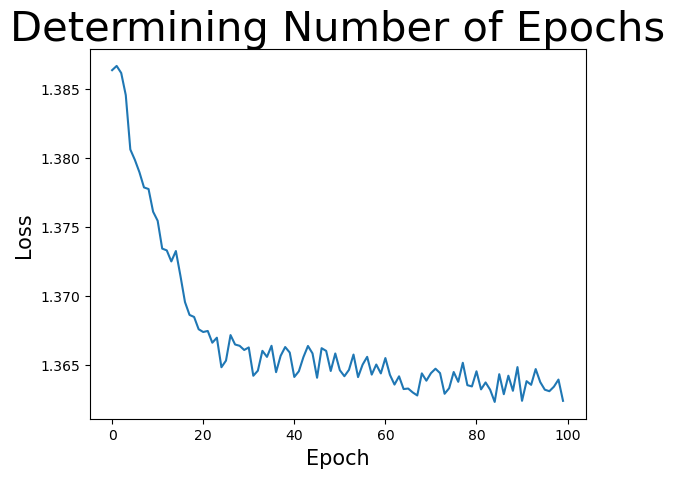

In [12]:
# Let's plot the loss
fig,axes = plt.subplots()
axes.plot(H.history['loss'])
plt.title('Determining Number of Epochs', fontsize = 30)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.show()
# fig.savefig("Final_Project_Epochs.png")

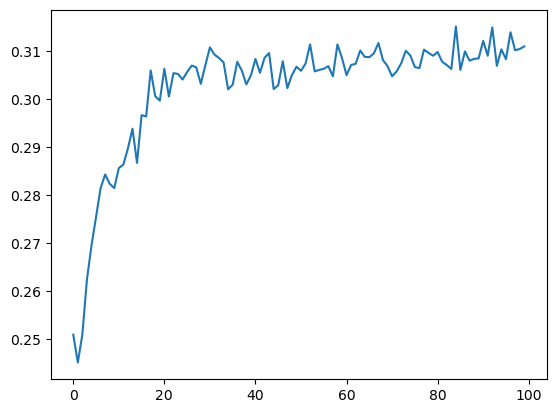

In [13]:
# Let's plot the accuracy
fig,axes = plt.subplots()
axes.plot(H.history['accuracy'])
plt.show()

# In both cases we can see for different sized epochs that around 100 is where
# no real improvement continues. This is the case for just about each model. So
# choose epochs = 100 in each cases.

In [14]:
####################################################
### How to make a prediction for a future value? ###
####################################################

print(x_test[-1])
# Output: array([-0.00525909,  0.00370393, -0.00768829])
# Check df:
print(df)
"""df
                   Open         High  ...  Log_Return      V_60
Date                                  ...                      
1950-03-29    17.440001    17.440001  ...   -0.005147  1.227366
1950-03-30    17.299999    17.299999  ...   -0.008060  1.376840
1950-03-31    17.290001    17.290001  ...   -0.000578  1.092282
1950-04-03    17.530001    17.530001  ...    0.013785  0.920911
1950-04-04    17.549999    17.549999  ...    0.001140  1.179001
...                 ...          ...  ...         ...       ...
2023-06-20  4396.109863  4400.149902  ...   -0.004746  1.007295
2023-06-21  4380.009766  4386.220215  ...   -0.005259  0.924596
2023-06-22  4355.399902  4382.250000  ...    0.003704  0.877794
2023-06-23  4354.169922  4366.549805  ...   -0.007688  1.500731
2023-06-26  4344.839844  4362.060059  ...   -0.004497  0.849170"""
# Matches up. Let's try to predict the Category of our Log(return) for
# June 27th, 2023.
# Use ([0.00370393, -0.00768829, -0.004497])
# June 27 Adj Close was 4,378.41 according to Yahoo Finance
# June 26 Adj Close was 4,328.82. This matches up with our df['Adj Close']
# log(Return) = np.log(4378.41/4328.82) = 0.011390657230512101
print(np.percentile(Y,25)) #-0.0041061114780562595
print(np.percentile(Y,50)) #0.0004807837607753272
print(np.percentile(Y,75)) #0.005042305721851345

# Therefore, our new log(return) > np.percentile(Y,75)
# Therefore our Log(Return) for the next day outside of the dataset would be
# classified as a 3 according to our discretization bins.

[-0.00525909  0.00370393 -0.00768829]
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1950-03-29    17.440001    17.440001    17.440001    17.440001    17.440001   
1950-03-30    17.299999    17.299999    17.299999    17.299999    17.299999   
1950-03-31    17.290001    17.290001    17.290001    17.290001    17.290001   
1950-04-03    17.530001    17.530001    17.530001    17.530001    17.530001   
1950-04-04    17.549999    17.549999    17.549999    17.549999    17.549999   
...                 ...          ...          ...          ...          ...   
2023-06-20  4396.109863  4400.149902  4367.189941  4388.709961  4388.709961   
2023-06-21  4380.009766  4386.220215  4360.140137  4365.689941  4365.689941   
2023-06-22  4355.399902  4382.250000  4351.819824  4381.890137  4381.890137   
2023-06-23  4354.169922  4366.549805  4341.339844  4348.330078  4348.330078   
2023-06-26  43

In [15]:
# Let's see how accurate our model would be for this:
prediction = model(np.array([[0.00370393, -0.00768829, -0.004497]]))
# Converting to a "probability"
to_probs = 1.0/(1.0 + np.exp(-prediction))
to_probs /= to_probs.sum()
print(to_probs)
# Output is scaled logits. We then change them to effecively be probabilities.
# In either case, the highest number is your best one!

#Output:
#[[0.2541748  0.26342106 0.26018417 0.22221997]]
# If we run this multiple times we will always get slightly different results.
# So our model thought the most likely outcome would be a 1 or 2, though a 0 is not
# too far behind. But 3 was the least likely! But if we check an actual figure of the SPX
# Close price it would show us that the model seemed to predict what should have happened,
# but some event ocurred which sent the stock up. When looking at a few other stocks (ex:
# Microsoft: MSFT, Target: TGT, Tesla: TSLA, and Walmart: WMT just to name a few) the same thing
# ocurred. This indicates that while our model may actually be okay, some shift happened in the
# market which we were not able to include in our model to handle this market shift. For Time Series
# these are referred to as shocks and the weakness of this Neural Network approach is that we cannot
# include exogenous variables to help us make predictions. 
# Another logical explanation is that our two most likely outcomes combined to be 52% likely. So there
# was actually quite a good chance that the value we attained would actually not be correct.

[[0.2618115  0.252188   0.25311595 0.2328846 ]]


In [16]:
############################
### Statistical Findings ###
############################

# The point of this exercise to to make sure that our NN Model allows us to determine
# a large decrease, small decrease, small increase, or large increase in the log returns
# of the next most trading day better than if we just guessed. Now since there are 4 
# possible outcomes, that means that by randomly guessing we would have a 25% chance of
# getting it right.

# 1 Sample Test for Binomial Proportion-Normal Theory method using a one-sided
# alternative.

# The one major assumption which we need to hold is the normal approximation to the
# Binomial distribution is valid i.e. n * p0 * (1-p0) >= 5.

# Ho : p0 = phat
# Ha : p0 < phat

p0 = 0.25
phat = model.evaluate(x_test, y_test, verbose=2)[1] # i.e. the sample proportion
# or accuracy obtained from our model
n = N - int(len(Y)*M)

z = (phat-p0)/(p0*(1-p0)/n)**0.5
# Compare z with 2.326348. If z > 2.326348 then statistically significant.

print()
print()
if z > 2.326348:
    print("Model does significantly better than random guessing")
else:
    print("Model does NOT do significantly better than random guessing")

print()
print()

58/58 - 0s - 2ms/step - accuracy: 0.3136 - loss: 1.3466


Model does significantly better than random guessing




In [17]:
###############
### Model 2 ###
###############

# NN Model using 3 consecutive Volume / 60 Day Moving Average's for Volume as the input, and the output
# is the discretized Y. This was not our main approach but it highlights some of the other avenues one
# might be interested in.

#M = float(input("Input what percentage of the data you want to be for training in (0.0,1.0): "))

x_train = V[:int(len(V)*M)]
y_train = Ydiscretize[:int(len(Y)*M)]
x_test  = V[int(len(V)*M):]
y_test  = Ydiscretize[int(len(Y)*M):]

# Build the model:
# Accuracy usually 0.255
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.Input(shape=(3,))) #x_train.shape = (int(len(V)*M),3)
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(72, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(72, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(60, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(48, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(36, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(24, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(12, activation=R))
model2.add(tf.keras.layers.Dropout(0.1))
model2.add(tf.keras.layers.Dense(4, activation=R))

# One massive hidden layer. Average accuracy was 0.254. Use the one above.
'''R = tf.keras.layers.LeakyReLU()
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(3,))) #x_train.shape = (int(len(X)*M),3)
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(2000, activation=R))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(4, activation=R))'''

# Sidenote: the model with a ton of hidden layers had accuracy roughly 0.25.

model2.compile(optimizer = 'adam',loss = loss_fn, metrics = ['accuracy'])

G = model2.fit(x_train, y_train, epochs=100, shuffle=True, verbose=2)
print("\nEvaluating on test set...")
# Evaluate the accuracy of the model on the test set:
model2.evaluate(x_test, y_test, verbose=2)
final_loss = G.history['loss'][-1]
final_accuracy = G.history['accuracy'][-1]

#Let's plot the loss
#fig,axes = plt.subplots()
#axes.plot(G.history['loss'])
#plt.show()

#Let's plot the accuracy
#fig,axes = plt.subplots()
#axes.plot(G.history['accuracy'])
#plt.show()"""

Epoch 1/100
519/519 - 7s - 14ms/step - accuracy: 0.2502 - loss: 1.3867
Epoch 2/100
519/519 - 3s - 5ms/step - accuracy: 0.2502 - loss: 1.3864
Epoch 3/100
519/519 - 2s - 4ms/step - accuracy: 0.2490 - loss: 1.3864
Epoch 4/100
519/519 - 2s - 4ms/step - accuracy: 0.2511 - loss: 1.3864
Epoch 5/100
519/519 - 2s - 4ms/step - accuracy: 0.2519 - loss: 1.3864
Epoch 6/100
519/519 - 2s - 3ms/step - accuracy: 0.2435 - loss: 1.3864
Epoch 7/100
519/519 - 2s - 3ms/step - accuracy: 0.2518 - loss: 1.3864
Epoch 8/100
519/519 - 2s - 3ms/step - accuracy: 0.2508 - loss: 1.3864
Epoch 9/100
519/519 - 2s - 3ms/step - accuracy: 0.2500 - loss: 1.3864
Epoch 10/100
519/519 - 2s - 3ms/step - accuracy: 0.2461 - loss: 1.3863
Epoch 11/100
519/519 - 2s - 3ms/step - accuracy: 0.2517 - loss: 1.3865
Epoch 12/100
519/519 - 2s - 3ms/step - accuracy: 0.2562 - loss: 1.3863
Epoch 13/100
519/519 - 2s - 3ms/step - accuracy: 0.2445 - loss: 1.3865
Epoch 14/100
519/519 - 2s - 4ms/step - accuracy: 0.2499 - loss: 1.3863
Epoch 15/100
5

In [18]:
############################
### Statistical Findings ###
############################

# 1 Sample Test for Binomial Proportion-Normal Theory method using a one-sided
# alternative.

# The one major assumption which we need to hold is the normal approximation to the
# Binomial distribution is valid i.e. n * p0 * (1-p0) >= 5.

# Ho : p0 = phat
# Ha : p0 < phat

p0 = 0.25
phat = model2.evaluate(x_test, y_test, verbose=2)[1] # i.e. the sample proportion
# or accuracy obtained from our model
n = N - int(len(Y)*M)

z = (phat-p0)/(p0*(1-p0)/n)**0.5
# Compare z with 2.326348. If z > 2.326348 then statistically significant.

print()
print()
if z > 2.326348:
    print("Model does significantly better than random guessing")
else:
    print("Model does NOT do significantly better than random guessing")

print()
print()

58/58 - 0s - 3ms/step - accuracy: 0.2366 - loss: 1.3852


Model does NOT do significantly better than random guessing




In [19]:
###############
### Model 3 ###
###############

# NN Model using 3 days worth of a log returns AND 60 Day Moving Average for Volume as the inputs, and the output
# is the discretized Y.

# M = float(input("Input what percentage of the data you want to be for training in (0.0,1.0): "))
# merged_array = np.stack([array_1, array_2], axis=1)
x_train = np.concatenate((X[:int(len(V)*M)], V[:int(len(V)*M)]),axis=1)
y_train = Ydiscretize[:int(len(Y)*M)]
x_test  = np.concatenate((X[int(len(V)*M):], V[int(len(V)*M):]),axis=1)
y_test  = Ydiscretize[int(len(Y)*M):]

# Build the model:
# Usually around 0.29 accuracy
R = tf.keras.layers.LeakyReLU()
model3 = tf.keras.models.Sequential()
model3.add(tf.keras.Input(shape=(6,)))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(72, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(72, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(60, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(48, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(36, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(24, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(12, activation=R))
model3.add(tf.keras.layers.Dropout(0.1))
model3.add(tf.keras.layers.Dense(4, activation=R))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
model3.compile(optimizer = 'adam',loss = loss_fn, metrics = ['accuracy'])

F = model3.fit(x_train, y_train, epochs=100, shuffle=True, verbose=2)
print("\nEvaluating on test set...")
# Evaluate the accuracy of the model on the test set:
model3.evaluate(x_test, y_test, verbose=2)
#final_loss = F.history['loss'][-1]
#final_accuracy = F.history['accuracy'][-1]

#Let's plot the loss
#fig,axes = plt.subplots()
#axes.plot(F.history['loss'])
#plt.show()

#Let's plot the accuracy
#fig,axes = plt.subplots()
#axes.plot(F.history['accuracy'])
#plt.show()

############################
### Statistical Findings ###
############################

#1 Sample Test for Binomial Proportion-Normal Theory method using a one-sided
#alternative.

#The one major assumption which we need to hold is the normal approximation to the
#Binomial distribution is valid i.e. n * p0 * (1-p0) >= 5.

#Ho : p0 = phat
#Ha : p0 < phat

p0 = 0.25
phat = model3.evaluate(x_test, y_test, verbose=2)[1] #i.e. the sample proportion
#or accuracy obtained from our model
n = N - int(len(Y)*M)

z = (phat-p0)/(p0*(1-p0)/n)**0.5
#Compare z with 2.326348. If z > 2.326348 then statistically significant.

print()
print()
if z > 2.326348:
    print("Model does significantly better than random guessing")
else:
    print("Model does NOT do significantly better than random guessing")

print()
print()

Epoch 1/100
519/519 - 7s - 13ms/step - accuracy: 0.2507 - loss: 1.3868
Epoch 2/100
519/519 - 2s - 4ms/step - accuracy: 0.2466 - loss: 1.3865
Epoch 3/100
519/519 - 2s - 3ms/step - accuracy: 0.2484 - loss: 1.3865
Epoch 4/100
519/519 - 2s - 4ms/step - accuracy: 0.2462 - loss: 1.3865
Epoch 5/100
519/519 - 2s - 4ms/step - accuracy: 0.2504 - loss: 1.3864
Epoch 6/100
519/519 - 2s - 3ms/step - accuracy: 0.2485 - loss: 1.3864
Epoch 7/100
519/519 - 2s - 3ms/step - accuracy: 0.2495 - loss: 1.3864
Epoch 8/100
519/519 - 2s - 4ms/step - accuracy: 0.2504 - loss: 1.3863
Epoch 9/100
519/519 - 2s - 3ms/step - accuracy: 0.2536 - loss: 1.3864
Epoch 10/100
519/519 - 2s - 3ms/step - accuracy: 0.2492 - loss: 1.3864
Epoch 11/100
519/519 - 3s - 5ms/step - accuracy: 0.2465 - loss: 1.3864
Epoch 12/100
519/519 - 2s - 3ms/step - accuracy: 0.2472 - loss: 1.3864
Epoch 13/100
519/519 - 2s - 3ms/step - accuracy: 0.2483 - loss: 1.3864
Epoch 14/100
519/519 - 2s - 3ms/step - accuracy: 0.2495 - loss: 1.3864
Epoch 15/100
5